In [1]:
import sys
sys.path.append("../../../../src")
sys.path.append("../../")
import os
import numpy as np
import pickle
from example_pendulum import get_pendulum_data
from autoencoder import full_network
from training import create_feed_dictionary
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
%matplotlib inline

tf.config.set_visible_devices([], 'GPU')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
data_path_original = '../../sindy_models/original/'
data_path_verification = '../../sindy_models/verification/'

save_names = {
    data_path_original + 'model1': 'O1',
    data_path_original + 'model2': 'O2', 
}

for i in range(1, 11):
    save_names[data_path_verification + f'V{i}'] = f'V{i}'

coefficient_names = np.array([r'1', r'z', r'\dot z',r'z^2', r'z\dot z', r'\dot z^2',r'z^3', r'z^2\dot z', r'z\dot z^2', r'\dot z^3', r'\sin(z)', r'sin(\dot z)'], dtype=object)

# Test all 10 replicated models

In [4]:
with open('../../test_data_max_variance.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [5]:
results = {k: {} for k in save_names}

In [8]:
for save_name in save_names:
    tf.reset_default_graph()
    params = pickle.load(open(save_name + '_params.pkl', 'rb'))
    params['save_name'] = save_name

    autoencoder_network = full_network(params)
    learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

    tensorflow_run_tuple = ()
    for key in autoencoder_network.keys():
        tensorflow_run_tuple += (autoencoder_network[key],)

    # Test
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, save_name)
        test_dictionary = create_feed_dictionary(test_data, params)
        tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

    test_set_results = {}
    for i,key in enumerate(autoencoder_network.keys()):
        test_set_results[key] = tf_results[i]

    results[save_name]['z'] = test_set_results['z']
    results[save_name]['dz'] = test_set_results['dz']
    results[save_name]['ddz'] = test_set_results['ddz']
    results[save_name]['coefficients'] = test_set_results['sindy_coefficients']
    results[save_name]['coefficient_mask'] = test_set_results['coefficient_mask']

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1
INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model2
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V1
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V2
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V3
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V4
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V5
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V6
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V7
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V8
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V9
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V10


In [7]:
from scipy.optimize import curve_fit
from tqdm import tqdm

In [8]:
def fit_func(w, a, b, c):
    return a * np.tanh(b * w - c) 

In [9]:
fit_parameters = {k: None for k in save_names}

for i, save_name in tqdm(enumerate(save_names)):
    cov = np.cov(results[save_name]['z'].flatten(), test_data['z'].flatten())[0, 1]
    fit_parameters[save_name] = curve_fit(fit_func, results[save_name]['z'].flatten(), test_data['z'].flatten(), maxfev=40000, p0=[cov, 1, 0])

12it [00:10,  1.17it/s]


In [10]:
adjusted_r_squared = {}

for k in save_names:
    SS_Residual = sum((test_data['z'].flatten()-fit_func(results[save_name]['z'].flatten(), *fit_parameters[save_name][0]))**2)
    SS_Total = sum((test_data['z'].flatten() - np.mean(test_data['z'].flatten()))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared[k] = 1 - (1-r_squared)*(len(test_data['z'].flatten())-1)/(len(test_data['z'].flatten())-3-1)

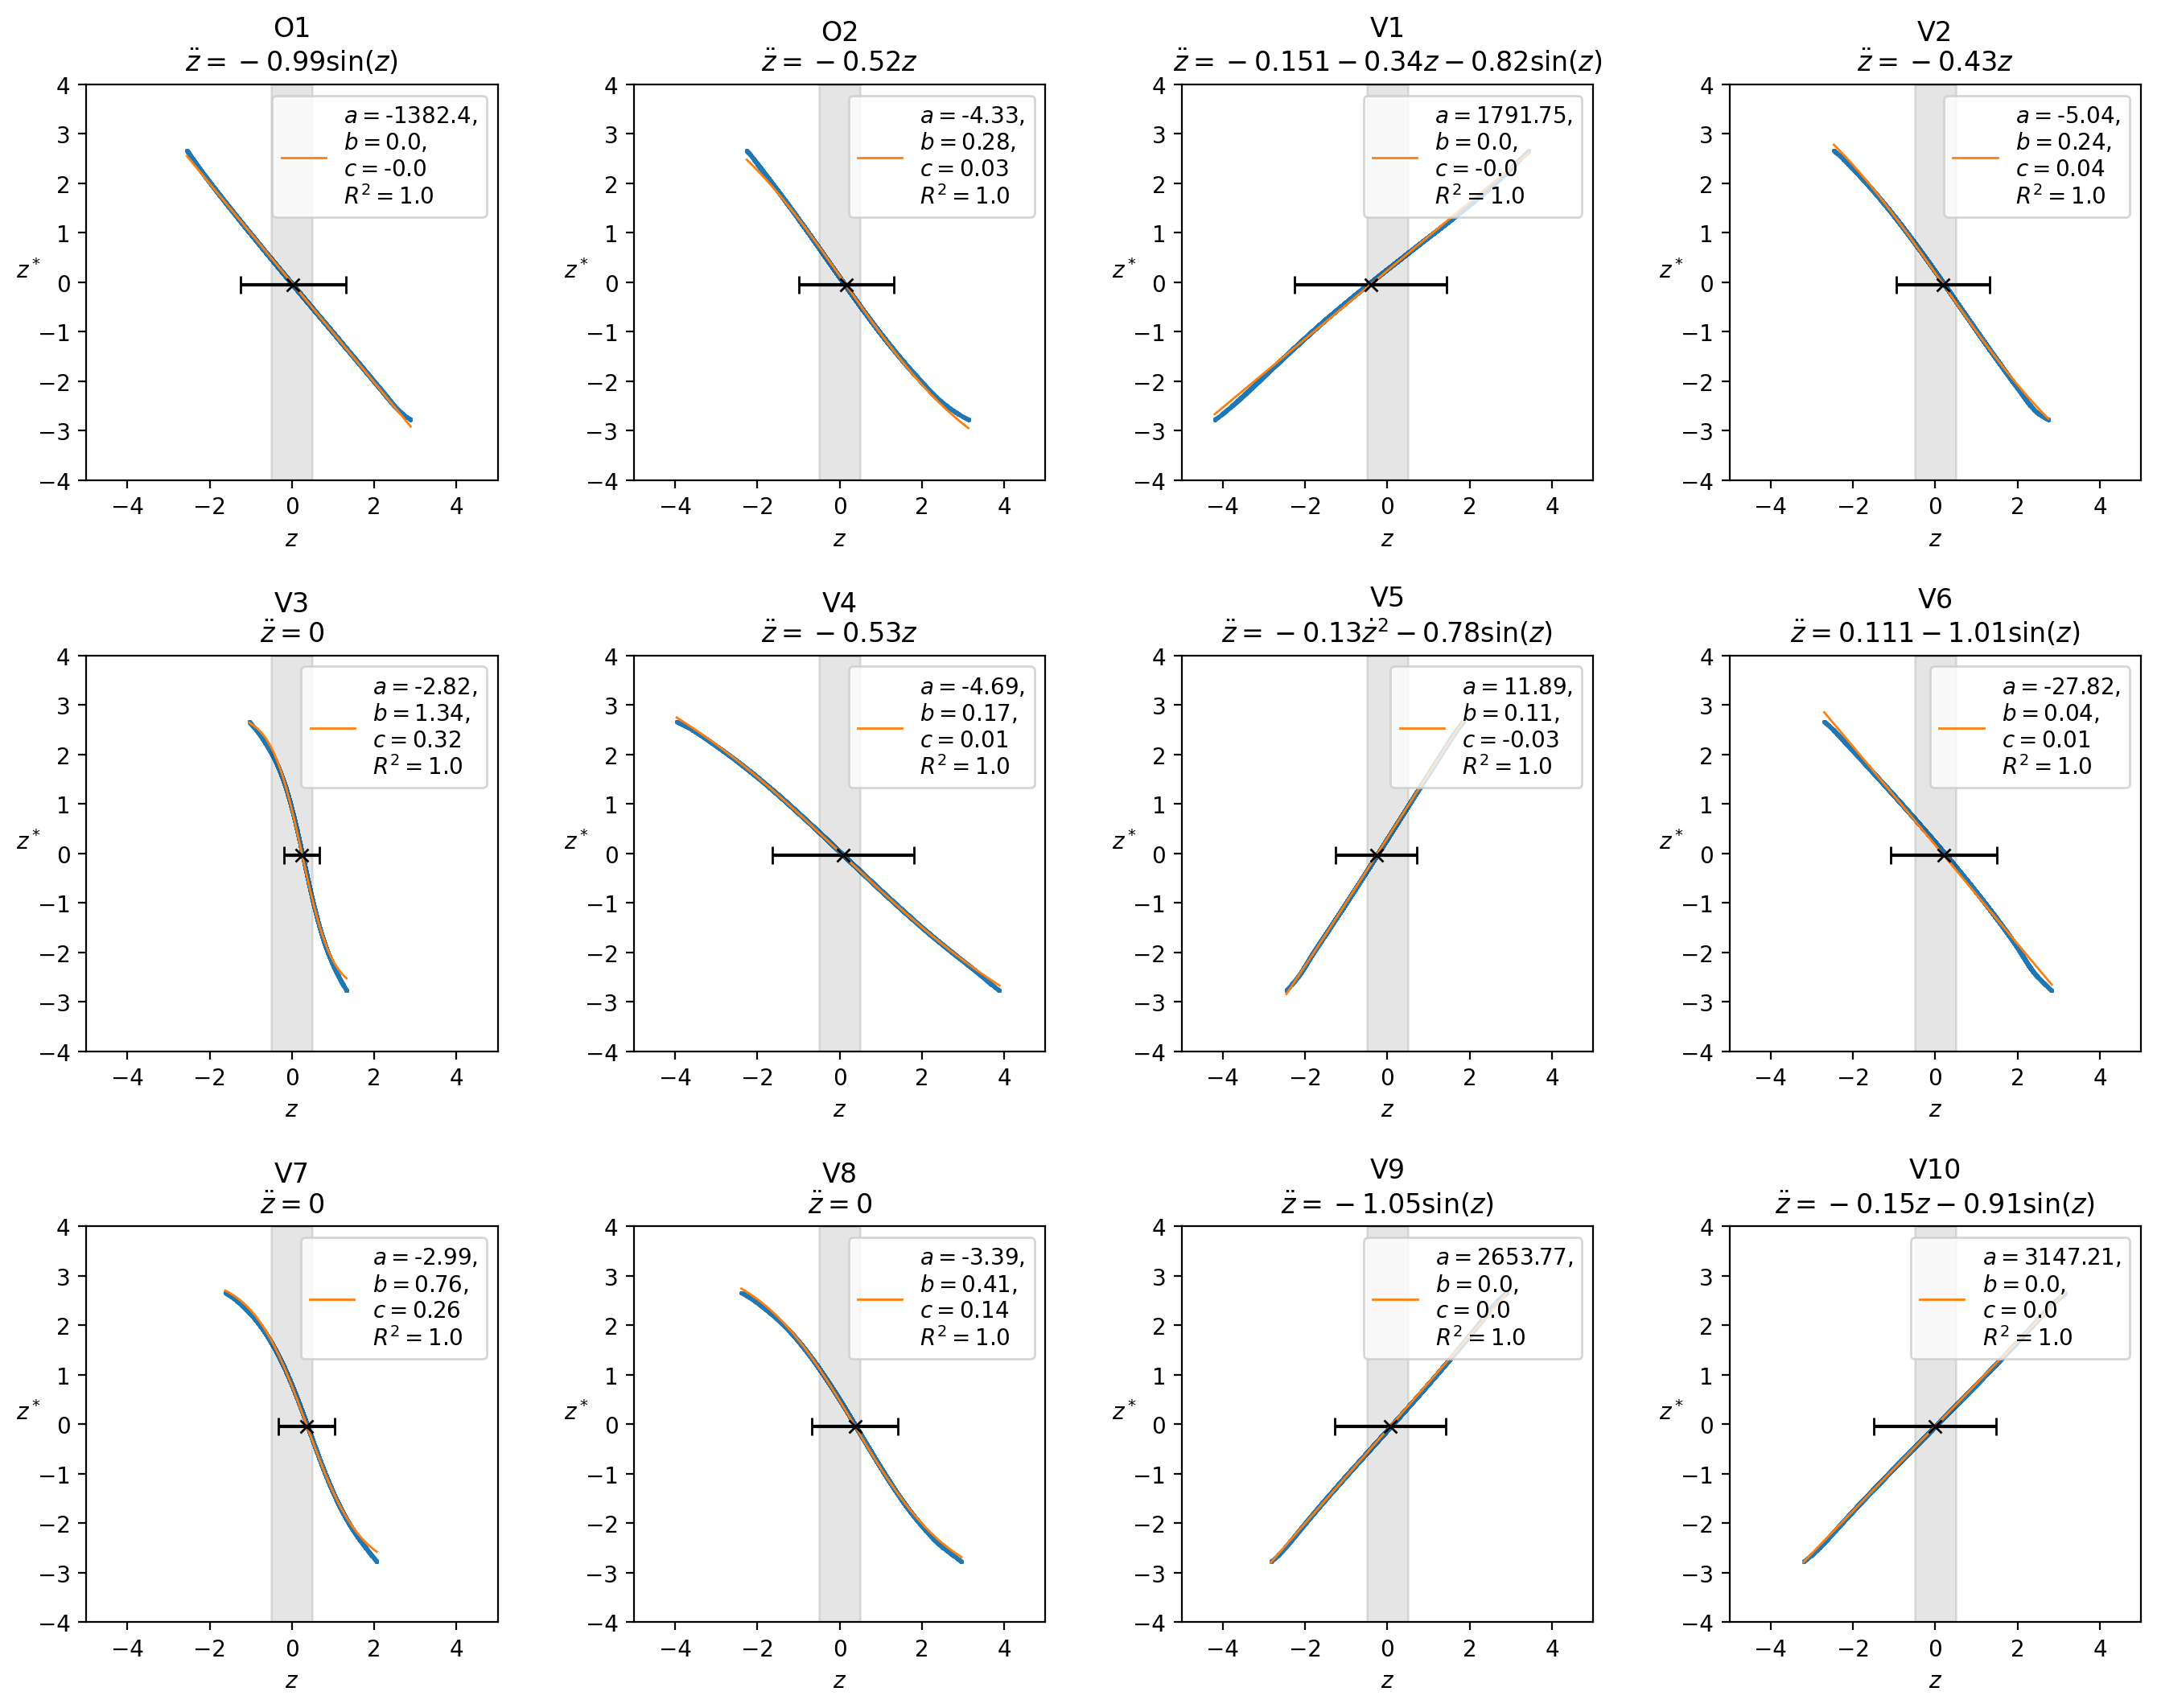

In [11]:
COLS = 4
a = 0.9

fig, axes = plt.subplots(3, COLS, figsize=(15 * a, 13 * a), dpi=200)
fig.tight_layout(w_pad=3, h_pad=7)
fig.subplots_adjust(top=0.85)

for i, save_name in enumerate(save_names):
    z_linspace = np.linspace(results[save_name]['z'].flatten().min(), results[save_name]['z'].flatten().max(), 100)
    axes[i//COLS][i%COLS].scatter(results[save_name]['z'].flatten(), test_data['z'].flatten(), s=0.5)
    axes[i//COLS][i%COLS].plot(z_linspace, fit_func(z_linspace, *fit_parameters[save_name][0]), color='tab:orange', linewidth=1,
        label=''.join(([r'$' + name + r' = $' + f'{fit_parameters[save_name][0][k].round(2)},\n' for k, name in enumerate(['a', 'b', 'c'])]))[:-2] + '\n' + r'$R^2 = $' + f'{adjusted_r_squared[save_name].round(2)}')

    eq = r'$\ddot z = '
    for j, (coef, coef_name) in enumerate(zip(results[save_name]['coefficients'], coefficient_names)):
        if not results[save_name]["coefficient_mask"].astype(bool).flatten()[j]: continue
        eq += ('+' if coef[0] >= 0 and eq != r'$\ddot z = ' else '') + f'{coef[0]:.2f}' + coef_name
    if not results[save_name]["coefficient_mask"].astype(bool).any(): eq += '0'
    eq += r'$'

    axes[i//COLS][i%COLS].errorbar([np.mean(results[save_name]['z'])], [np.mean(test_data['z'])], xerr=[np.std(results[save_name]['z'])], capsize=4, fmt='x', label=None, color='black') #r'$z$'+'-Distribution (mean' + r'$\pm$' + 'std)' if i == 0 else 
    axes[i//COLS][i%COLS].axvspan(-0.5, 0.5, color='black', alpha=0.1, label=None)
    axes[i//COLS][i%COLS].set_title((f'V{i-1}' if i > 1 else f'O{i+1}') + '\n' + eq)
    axes[i//COLS][i%COLS].legend(loc='upper right');
    axes[i//COLS][i%COLS].set_xlabel(r'$z$'); axes[i//COLS][i%COLS].set_ylabel(r'$z^*$', rotation=0); axes[i//COLS][i%COLS].set_ylim(-4, 4); axes[i//COLS][i%COLS].set_xlim(-5, 5)

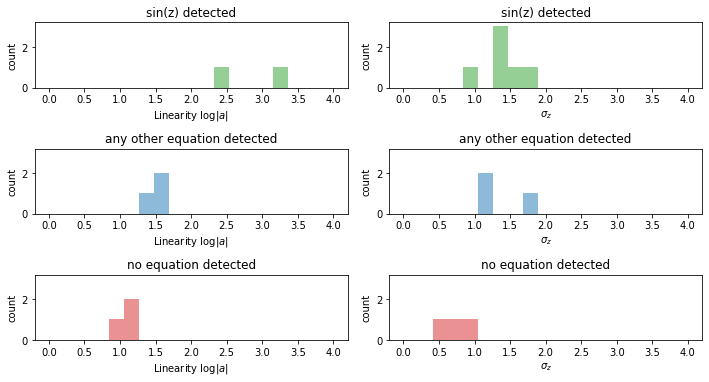

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(10, 5))
fig.tight_layout(h_pad=4)
bins = np.linspace(0, 4, 20)

axes[0][0].hist(np.log(np.abs([fit_parameters[save_names[i]][0][0] for i in range(len(save_names)) if i in [0, 2, 6, 7, 10, 11]])), bins=bins, alpha=0.5, color='tab:green')
axes[0][0].set_title('sin(z) detected')
axes[1][0].hist(np.log(np.abs([fit_parameters[save_names[i]][0][0] for i in range(len(save_names)) if i in [1, 3, 5]])), bins=bins, alpha=0.5, color='tab:blue')
axes[1][0].set_title('any other equation detected')
axes[2][0].hist(np.log(np.abs([fit_parameters[save_names[i]][0][0] for i in range(len(save_names)) if i not in [0, 2, 6, 7, 10, 11, 1, 3, 5]])), bins=bins, alpha=0.5, color='tab:red')
axes[2][0].set_title('no equation detected')

for ax in axes[:, 0]:
    ax.set_ylim(0, 3.2)
    ax.set_xlabel(r'Linearity $\log|a|$'); ax.set_ylabel('count')

bins = np.linspace(0, 4, 20)
axes[0][1].hist([np.std(results[save_names[i]]['z']) for i in range(len(save_names)) if i in [0, 2, 6, 7, 10, 11]], bins=bins, alpha=0.5, color='tab:green')
axes[0][1].set_title('sin(z) detected')
axes[1][1].hist([np.std(results[save_names[i]]['z']) for i in range(len(save_names)) if i in [1, 3, 5]], bins=bins, alpha=0.5, color='tab:blue')
axes[1][1].set_title('any other equation detected')
axes[2][1].hist([np.std(results[save_names[i]]['z']) for i in range(len(save_names)) if i not in [0, 2, 6, 7, 10, 11, 1, 3, 5]], bins=bins, alpha=0.5, color='tab:red')
axes[2][1].set_title('no equation detected')

for ax in axes[:, 1]:
    ax.set_ylim(0, 3.2)
    ax.set_xlabel(r'$\sigma_z$'); ax.set_ylabel('count')

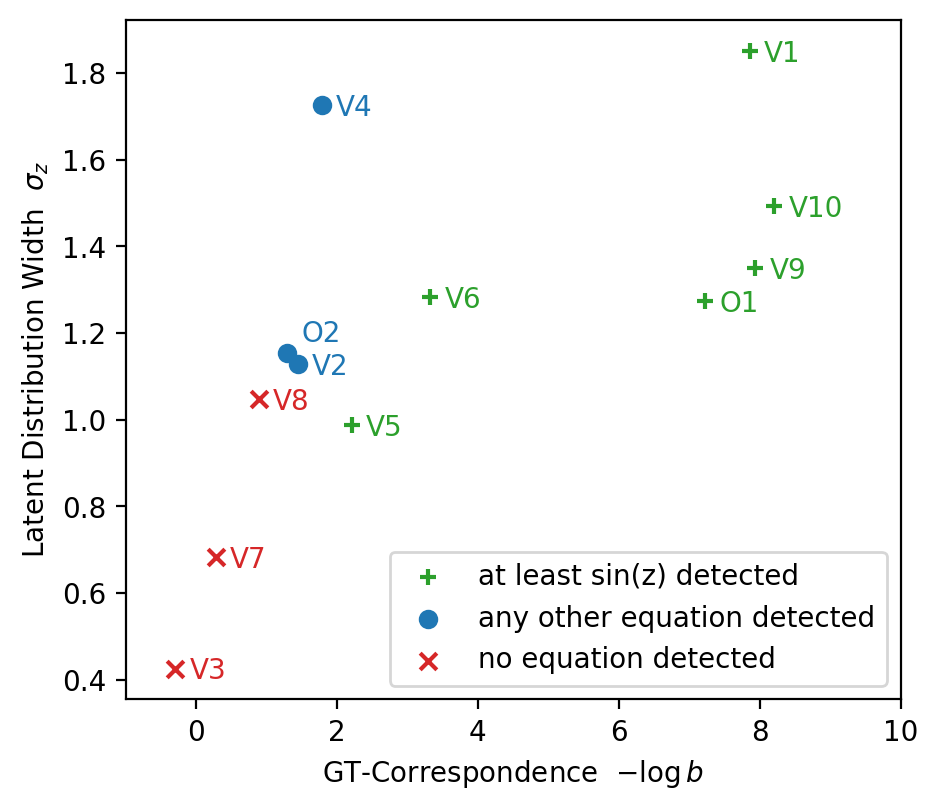

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), dpi=200)

x_list = [
    np.log(np.abs([1 / fit_parameters[save_names[i]][0][1] for i in range(len(save_names)) if i in [0, 2, 6, 7, 10, 11]])),
    np.log(np.abs([1 / fit_parameters[save_names[i]][0][1] for i in range(len(save_names)) if i in [1, 3, 5]])),
    np.log(np.abs([1 / fit_parameters[save_names[i]][0][1] for i in range(len(save_names)) if i not in [0, 2, 6, 7, 10, 11, 1, 3, 5]])),
]

x_list = [
    -np.log([fit_parameters[save_names[i]][0][1] for i in range(len(save_names)) if i in [0, 2, 6, 7, 10, 11]]),
    -np.log([fit_parameters[save_names[i]][0][1] for i in range(len(save_names)) if i in [1, 3, 5]]),
    -np.log([fit_parameters[save_names[i]][0][1] for i in range(len(save_names)) if i not in [0, 2, 6, 7, 10, 11, 1, 3, 5]]),
]

y_list = [
    [np.std(results[save_names[i]]['z']) for i in range(len(save_names)) if i in [0, 2, 6, 7, 10, 11]],
    [np.std(results[save_names[i]]['z']) for i in range(len(save_names)) if i in [1, 3, 5]],
    [np.std(results[save_names[i]]['z']) for i in range(len(save_names)) if i not in [0, 2, 6, 7, 10, 11, 1, 3, 5]],
]

labels = ['at least sin(z) detected', 'any other equation detected', 'no equation detected']

colors = ['tab:green', 'tab:blue', 'tab:red']

names_list = [
    [(f'V{i-1}' if i > 1 else f'O{i+1}') for i in range(len(save_names)) if i in [0, 2, 6, 7, 10, 11]],
    [(f'V{i-1}' if i > 1 else f'O{i+1}') for i in range(len(save_names)) if i in [1, 3, 5]],
    [(f'V{i-1}' if i > 1 else f'O{i+1}') for i in range(len(save_names)) if i not in [0, 2, 6, 7, 10, 11, 1, 3, 5]]
]

for x, y, label, names, color, f in zip(x_list, y_list, labels, names_list, colors, ['+', 'o', 'x']):
    ax.scatter(x,y, color=color, label=label, marker=f)
    for xi, yi, name in zip(x, y, names):
        ax.text(xi + 0.2, yi - 0.025 + (0.05 * (name == 'O2')), name, color=color)

ax.set_xlabel(r'GT-Correspondence  $-\log b$'); ax.set_ylabel(r'Latent Distribution Width  $\sigma_z$'); ax.legend(loc='lower right'); ax.set_xlim(-1, 10); #ax.set_title('Failure Effects of the Pendulum Models')